## Regression Model for USDA Beef Grading

This model will use pytoch and resnet to make a CNN regression model (convolutional neural network)
hay que mantener 5 pasos
1. cargando imagenes y procesarlos
2. modificar el modelo resnet para la regresion
3. entrenar el model
4. evaluar modelo (root mean square)

In [13]:
import torch
import torchvision
import os
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms, models
import torch.optim as optim
import pandas as pd
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights, VGG16_Weights, AlexNet_Weights
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import random


from PIL import Image


from sklearn.metrics import mean_squared_error

print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


In [6]:
root_folder =  "Data/Cleaned JPEG Images"
training_folders = [
    "Cargill Dodge 07 20 22 Plant", 
    "Cargill Fort Morgan 03 28 22 Plant",
    "Cargill Schuyler 04 01 22 Plant",
    "Cargill Fort Morgan 07 15 22 Plant"
]

eval_folders= [
    "Cargill Friona 07 18 22 Plant",
    "Cargill Schuyler 07 18 22 Plant",
]

test_folder= ["Cargill Fort Morgan 05 12 22 Plant"]
#df = pd.read_excel(excel_path)

#df.columns = df.columns.str.strip()
#ID_to_score = dict(zip(df['CarcassId'], df['Average']))
#ID_to_score = {f"{carcass_id}.jpg": avg for carcass_id, avg in zip(df['ID'], df['AVG'])}

#print(ID_to_score.keys())

def DataPrepare(root_folder, input_folders):
    all_image_addresses= []
    all_Scores = []
    all_image_ids = []
    total_image_number = 0
    for i in range((len(input_folders))):
        img_folder_name = root_folder + "/" +  input_folders[i] + "/Images/"
        Scores_name = root_folder + "/" + input_folders[i] + "/data.xlsx"
        df = pd.read_excel(Scores_name)
        for _, _, files in os.walk(img_folder_name):
            for filename in files:
                total_image_number += 1
                all_image_addresses.append(img_folder_name + filename)
                all_image_ids.append(filename[0:-4])
                Score_value = df.at[int(df.index[df['ID'] == filename[0:-4]][0]), 'AVG']
                all_Scores.append(Score_value)
    return all_image_addresses, all_Scores, all_image_ids, total_image_number

class ImageDataset(Dataset):
    def __init__(self, root_folder, input_folders, transform =None):
        self.img_dirs, self.scores, self.image_ids, self.img_num = DataPrepare(root_folder, input_folders)
        self.transform = transform
                
    def __len__(self):
        return self.img_num
        
    def __getitem__(self, idx):
        image = Image.open(self.img_dirs[idx])
        if self.transform:
            image = self.transform(image)
        score = self.scores[idx] / 1500
        image_id = self.image_ids[idx]
        return image, score, image_id
      

# Transforms and model

In [7]:
general_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

traindataset = ImageDataset(root_folder, training_folders, transform=general_transform)
traindataloader= DataLoader(traindataset, batch_size=32, shuffle=True)

evaluatedataset= ImageDataset(root_folder, eval_folders, transform=general_transform)
evaluatedataloader= DataLoader(evaluatedataset, batch_size=32, shuffle=False)

testdataset= ImageDataset(root_folder, test_folder, transform=general_transform)
testdataloader= DataLoader(testdataset, batch_size=32, shuffle = False)

In [8]:

#pretrained resnet, 50
#resnet18 = torch.hub.load("pytorch/vision", "resnet18", weights=ResNet18_Weights.DEFAULT)
#resnet18save_model_name = './resnet18_predict_best.pt'
#resnet18.fc = nn.Sequential(
#    nn.Linear(2048,512),
#    nn.ReLU(inplace=True),
#    nn.Linear(in_features=512, out_features=1, bias=True),
#    nn.Sigmoid(),
#)
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features,1) #output 1 for regression\n",

vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)


num_features_vgg = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features_vgg, 1)

num_features_alexnet = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features_alexnet, 1)

'''
##pretrained AlexNet
alexnet = torch.hub.load("pytorch/vision", "alexnet", weights=AlexNet_Weights.DEFAULT)
alexnet_save_model_name = './AlexNet_predict_best.pt'
alexnet.classifier = nn.Sequential(
         nn.Linear(9216,512),
         nn.ReLU(inplace=True),
         nn.Linear(512, 64),
         nn.ReLU(inplace=True),
         nn.Linear(64, 1),
         nn.Sigmoid(),
         )

#pretrained vgg16
vgg16 = torch.hub.load("pytorch/vision", "vgg16", weights=VGG16_Weights.DEFAULT)
vgg16save_model_name= './vgg16_predict_best.pt'
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(inplace= True),
    nn.Linear(512, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 1),
    nn.Sigmoid(),
)


'''
#LOAD IN THE GPU (MUY IMPORTANTE NO OLVIDES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


resnet18 = resnet18.to(device)
#vgg16 = vgg16.to(device)
#alexnet = alexnet.to(device)

cuda


# Training Loop

Training dataset on model: ResNet
Epoch [1/65], Loss: 0.9939
Epoch [2/65], Loss: 0.0082
Epoch [3/65], Loss: 0.0032
Epoch [4/65], Loss: 0.0027
Epoch [5/65], Loss: 0.0024
Epoch [6/65], Loss: 0.0026
Epoch [7/65], Loss: 0.0023
Epoch [8/65], Loss: 0.0018
Epoch [9/65], Loss: 0.0015
Epoch [10/65], Loss: 0.0018
Epoch [11/65], Loss: 0.0019
Epoch [12/65], Loss: 0.0012
Epoch [13/65], Loss: 0.0016
Epoch [14/65], Loss: 0.0018
Epoch [15/65], Loss: 0.0011
Epoch [16/65], Loss: 0.0017
Epoch [17/65], Loss: 0.0019
Epoch [18/65], Loss: 0.0011
Epoch [19/65], Loss: 0.0022
Epoch [20/65], Loss: 0.0011
Epoch [21/65], Loss: 0.0006
Epoch [22/65], Loss: 0.0004
Epoch [23/65], Loss: 0.0004
Epoch [24/65], Loss: 0.0004
Epoch [25/65], Loss: 0.0006
Epoch [26/65], Loss: 0.0004
Epoch [27/65], Loss: 0.0004
Epoch [28/65], Loss: 0.0005
Epoch [29/65], Loss: 0.0004
Epoch [30/65], Loss: 0.0003
Epoch [31/65], Loss: 0.0004
Epoch [32/65], Loss: 0.0005
Epoch [33/65], Loss: 0.0005
Epoch [34/65], Loss: 0.0005
Epoch [35/65], Loss: 0.

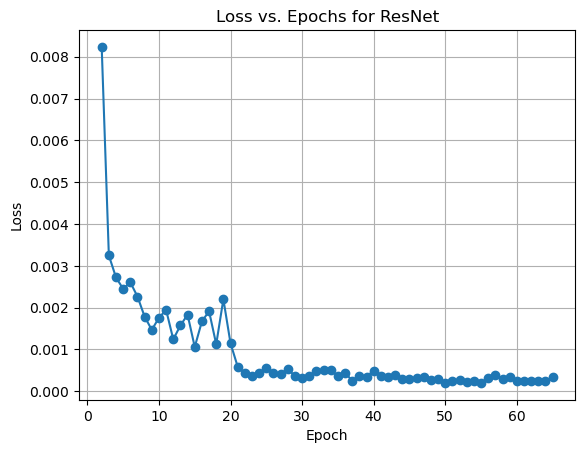

In [9]:
def train_model(model, num_epochs, dataloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    num_epochs = 65
    model_name = model.__class__.__name__  # Get the model class name
    print(f"Training dataset on model: {model_name}")
    loss_values = []
    
    for epoch in range(num_epochs):
        running_loss =0.0
        for images, scores, _ in dataloader:
            images = images.to(device)
            scores = scores.to(device).view(-1,1).float()
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, scores)
            
            #backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        scheduler.step()
        
        epoch_loss = running_loss / len(dataloader)
        if epoch > 0:
            loss_values.append(epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')
        
    print(f'Training completed! for ({model_name})')

    plt.plot(range(2, num_epochs + 1), loss_values, marker='o')
    plt.title(f'Loss vs. Epochs for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return model

resnet18 = train_model(resnet18, 65, traindataloader)
#vgg16 = train_model(vgg16, 65, traindataloader)
#alexnet = train_model(alexnet, 65, traindataloader)

# Evaluation

In [10]:
def evaluate_model(model, dataloader):
    model_name = model.__class__.__name__  # Get the model class name
    model.eval()
    all_preds = []
    all_scores = []
    with torch.no_grad():
        for images, scores, _ in dataloader:
            images = images.to(device)
            scores = scores.to(device).view(-1,1).float()
            outputs = model(images)
            all_preds.append(outputs.cpu().numpy())
            all_scores.append(scores.cpu().numpy())
            
    all_preds = np.concatenate(all_preds)
    all_scores = np.concatenate(all_scores)
    mse = mean_squared_error(all_scores, all_preds)
    rmse = np.sqrt(mse)
    
    print(f'RMSE ({model_name}): {rmse*1500:.4f}')
    return rmse

evaluate_model(resnet18, evaluatedataloader)
#evaluate_model(vgg16, evaluatedataloader)
#evaluate_model(alexnet, evaluatedataloader)
evaluate_model(resnet18, testdataloader)

RMSE (ResNet): 62.4555
RMSE (ResNet): 62.8391


0.041892737

# Misc / Junk Code

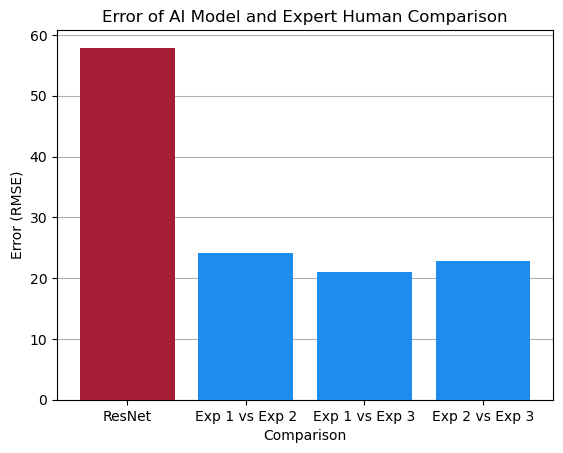

In [11]:
comparisons = ['ResNet', 'Exp 1 vs Exp 2', 'Exp 1 vs Exp 3', 'Exp 2 vs Exp 3']
errors = [57.9, 24.1, 21.0, 22.9]

colors = ['#a41e35', '#1e8ced', '#1e8ced', '#1e8ced']
# Create the bar chart
plt.bar(comparisons, errors, color=colors, zorder=3)

# Add title and labels
plt.title('Error of AI Model and Expert Human Comparison')
plt.xlabel('Comparison')
plt.ylabel('Error (RMSE)')

plt.grid(True, axis='y', zorder=0)
# Display the bar chart
plt.show()

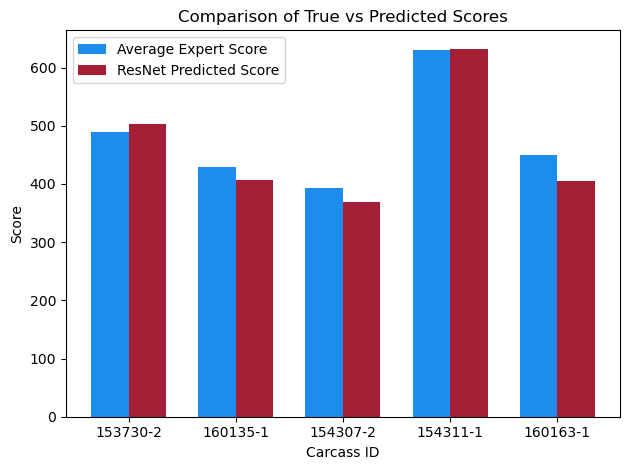

In [18]:
def compare_predictions(model, dataloader, num_samples):
    model.eval()
    all_preds = []
    all_scores = []
    all_ids = []  # To store the Carcass IDs
    
    # Collect predictions, actual scores, and carcass IDs
    with torch.no_grad():
        for images, scores, image_ids in dataloader:
            images = images.to(device)
            scores = scores.to(device).view(-1, 1).float()
            outputs = model(images)
            
            all_preds.extend(outputs.cpu().numpy())  # Collect predictions
            all_scores.extend(scores.cpu().numpy())  # Collect true scores
            all_ids.extend(image_ids)  # Collect Carcass IDs
    
    # Randomly select some sample indices
    sample_indices = random.sample(range(len(all_preds)), num_samples)
    selected_preds = [all_preds[i][0] for i in sample_indices]  # Flatten the 2D array to 1D
    selected_scores = [all_scores[i][0] for i in sample_indices]  # Flatten the 2D array to 1D
    selected_ids = [all_ids[i] for i in sample_indices]  # Get the Carcass IDs for selected samples
    
    # Create a bar chart to compare true vs predicted scores
    bar_width = 0.35
    indices = range(num_samples)

    plt.bar(indices, [score * 1500 for score in selected_scores], bar_width, label='Average Expert Score', color='#1e8ced')
    plt.bar([i + bar_width for i in indices], [pred * 1500 for pred in selected_preds], bar_width, label='ResNet Predicted Score', color='#a41e35')
    
    plt.xlabel('Carcass ID')
    plt.ylabel('Score')
    plt.title('Comparison of True vs Predicted Scores')
    plt.xticks([i + bar_width / 2 for i in indices], selected_ids)  # Use Carcass IDs as x-axis labels
    plt.legend()

    plt.tight_layout()
    plt.show()

# Compare predictions for 5 random samples from evaluation dataset
compare_predictions(resnet18, evaluatedataloader, 5)


Text(0, 0.5, 'Error (RMSE)')

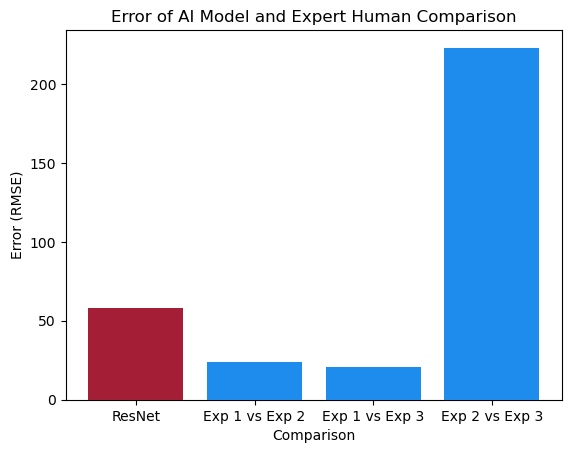

In [3]:
comparisons = ['ResNet', 'Exp 1 vs Exp 2', 'Exp 1 vs Exp 3', 'Exp 2 vs Exp 3']
errors = [57.9, 24.1, 21.0, 222.9]

colors = ['#a41e35', '#1e8ced', '#1e8ced', '#1e8ced']
# Create the bar chart
plt.bar(comparisons, errors, color=colors, zorder=3)

# Add title and labels
plt.title('Error of AI Model and Expert Human Comparison')
plt.xlabel('Comparison')
plt.ylabel('Error (RMSE)')
